# Bonus Example: Out-of-Sample Share Price Simulation using Geometric Brownian Motion
This example will familiarize students with creating single-asset geometric Brownian motion simulations of out-of-sample data. We'll use GBM parameters estimated from past data (`2018` to `2023`) to initialize a GBM model and simulate future share prices, i.e., from `01-03-24` until `09-23-24`.

### Learning objectives
* __Prerequisites__: we'll begin by loading the dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2024` until `09-23-2024`. We'll also load the historical lattice parameters.
* __Task 1__: Construct an out-of-sample GBM model. In this task, we build a GBM model to simulate data we have not seen before. We used `2018` to `2023` data to estimate the drift and volatility parameters, but we'll now run price simulations for `2024` data.
* __Task 2__: Compare GBM model prediction versus market observations. In this task, we'll visualize and compare the model simulations with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time and compare those values with what was observed in the market.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the testing dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until last week `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `prediction_dataset` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
prediction_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 488 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "UNP"  => 182×8 DataFrame…
  ⋮      => ⋮

Next, let's get a list of firms in the `prediction_dataset,` and save it in the `list_of_all_tickers::String` array:

In [7]:
list_of_all_tickers = keys(prediction_dataset) |> collect |> sort;

Finally, we saved the estimated real-world GBM model parameters using data from 2018 to 2023, so let's load the saved parameter file to initialize our GBM model.
* Load the $(\hat{\mu},\hat{\sigma})$ dataset we computed previously [using `read(...)` method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) and store this in the `parameters_df::DataFrame` variable. 

In [9]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023-Backup.csv"), DataFrame);

Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, the units, permissible values, etc.

In [11]:
Δt = (1.0/252); # step size: 1-trading day in units of years
risk_free_rate = 0.0; # hypothetical continuously compounding risk-free rate

## Task 1: Construct an out-of-sample GBM model
In this task, we build a single asset GBM model to simulate data we have not seen before. We used `2018` to `2023` data to estimate the model parameters, but we'll now run price simulations for `2024` data.

For the out-of-sample simulation, let's begin by specifying a `my_ticker_of_interest::String` and a `start_index::Int64` value. Note that when specifying the ticker to simulate, we must select a value in the `parameters_df::DataFrame` dataframe. 

In [13]:
my_ticker_of_interest = "SPY";

Next, we select the parameters for `my_favorite_ticker::String.` We'll store these in the `my_parameters` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow).

In [15]:
my_parameters = findfirst(x->x==my_ticker_of_interest, parameters_df[:,:ticker]) |> i-> parameters_df[i,:] 

Row,ticker,drift,volatility
,String7,Float64,Float64
377,SPY,0.100555,0.109962


We can get the parameters from the `my_parameters::DataFrameRow` by passing in the column name to `my_parameters` row model [as a Julia Symbol](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols)

In [17]:
μ̂ = my_parameters[:drift]; # drift parameter
σ̂ = my_parameters[:volatility]; # volatility parameter

Now build an instance of the [MyGeometricBrownianMotionEquityModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), where you pass in values for the $(\hat{\mu},\hat{\sigma})$ parameters as arguments to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). Store this in the `model` variable:

In [19]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

To simulate the GBM model, we need to specify the `number_of_samples,` i.e., the number of trajectories to compute, the initial share price `Sₒ,` the initial time `T₁,` the final time `T₂.` Pass these (along with your `model` instance) into the [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}). 
* The [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_samples` possible price trajectories from $T_{1}\rightarrow{T}_{2}$ using the GBM `model` instance. The simulation data is returned as an array, where the first column in the time and columns `2:end` hold simulated trajectories. Store this in the variable `X`

In [21]:
number_of_samples = 250; # how many different futures should we simulate
my_firm_dataset = prediction_dataset[my_ticker_of_interest]
Sₒ = my_firm_dataset[1, :volume_weighted_average_price];
T₁ = 0*Δt
T₂ = (nrow(my_firm_dataset)-1)*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_samples);

## Task 2: Compare model prediction versus market observations
In this task, we'll visualize and compare the GBM model simulations with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time.

In addition to the numerical samples in the `X` array, we have analytical expressions for both the expected value and the variance of the share price. We've implemented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions. Let's call these functions to get analytical values for the expectation_arra and variance of the `VWAP.`

In [23]:
expectation_array = expectation(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance_array = variance(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

`Unhide` the block below to see how to plot the expected value and the variance of the simulated share price versus the actual shore price, as well as the sampled trajectories.

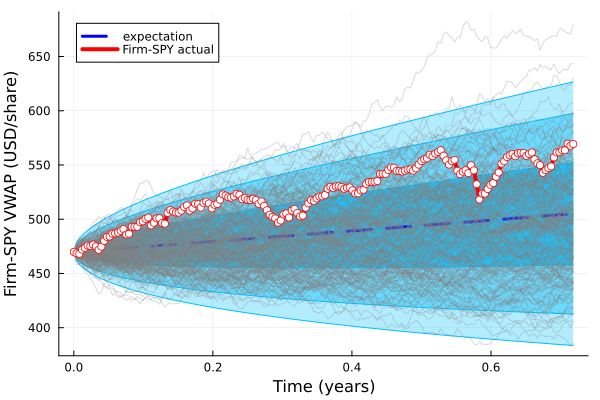

In [25]:
let
    L68 = expectation_array[:,2] .- sqrt.(variance_array[:,2])
    U68 = expectation_array[:,2] .+ sqrt.(variance_array[:,2])
    L95 = expectation_array[:,2] .- 1.96*sqrt.(variance_array[:,2])
    U95 = expectation_array[:,2] .+ 1.96*sqrt.(variance_array[:,2])
    L99 = expectation_array[:,2] .- 2.576*sqrt.(variance_array[:,2])
    U99 = expectation_array[:,2] .+ 2.576*sqrt.(variance_array[:,2])

    plot(expectation_array[:,1], expectation_array[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.75, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation_array[:,1], expectation_array[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.3, label="")

    plot!(expectation_array[:,1], expectation_array[:,2],c=:blue, lw=3,ls=:dash, label="expectation")
    plot!(expectation_array[:,1], L68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U68, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U95, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], L99, c=:deepskyblue1, lw=1, label="")
    plot!(expectation_array[:,1], U99, c=:deepskyblue1, lw=1, label="")

    plot!(X[:,1],X[:,2:end], label="", c=:gray50, alpha=0.3)
    plot!(X[:,1], my_firm_dataset[1:end, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(my_ticker_of_interest) actual")
     scatter!(X[1:end,1], my_firm_dataset[1:end, :volume_weighted_average_price], 
        label="", msc=:red, mc=:white)


    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(my_ticker_of_interest) VWAP (USD/share)", fontsize=18)
end

#### Check: Was this a successful GBM simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [27]:
let
    z = 2.576;
    L = expectation_array[:,2] .- z*sqrt.(variance_array[:,2])
    U = expectation_array[:,2] .+ z*sqrt.(variance_array[:,2])
    T = nrow(my_firm_dataset);
    start_index = 1;
    stop_index = T;
    
    # check the bounds: if below L, or above U then the simulation failed
    success_flag = true;
    for k ∈ 1:T
        if (my_firm_dataset[start_index+k-1,:volume_weighted_average_price] < L[k]) || (my_firm_dataset[start_index+k-1,:volume_weighted_average_price] > U[k])
            success_flag = false;
            break;
        end
    end
    
    println("The simulation of the VWAP of Firm-$(my_ticker_of_interest) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")
end

The simulation of the VWAP of Firm-SPY between (1 -> 182) was successful: true


## Task 3: Compute the probability of profit using GBM
In this task, we will use a GBM model to compute the probability of profit (POP) for an equity trade using geometric Brownian motion (GBM) to estimate the future share price.

Let's start by specifying the range of the fractional profit (loss) that we are interested in, which we store this in the `minumum_fractional_return::Array{Float64,1}` array:

In [29]:
number_of_test_points = 41;
minumum_fractional_return = range(-0.5,stop=0.5,length=number_of_test_points) |> collect;

Next, we'll estimate [the cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the fractional return, i.e., the scaled net present value for `2024` for `my_ticker_of_interest::String.`
* __Strategy__: For each potential hypothetical future (specified by the `number_of_samples::Int64` variable), compute the fraction of these futures that are less than or equal to elements of the `minumum_fractional_return::Array{Float64,1}` array. This gives us an estimate of $P(X\leq{x})$. In the $P(X\leq{x})$ expression, big $X$ is a random value (observed fractional return), and $x$ is a specified value (desired fractional return).
* `Unhide` the code block below to see how we estimated $P(X\leq{x})$ for each element of the `minumum_fractional_return` array. We store these results in the `cumulative_probability_array::Array{Float64,2}` variable, where each row corresponds to a different desired fractional return, the first column in the fractional return $x$ and the second column holds the $P(X\leq{x})$ values.

In [31]:
cumulative_probability_array = let

    cumulative_probability_array = Array{Float64,2}(undef, number_of_test_points, 2);
    for i ∈ eachindex(minumum_fractional_return)
        test_return = minumum_fractional_return[i];
    
        N₊ = 0; # How many positive examples do we have?
        for j ∈ 1:number_of_samples
            Sₒ = X[1,j+1]; # initial share price
            S = X[end,j+1]; # final price, col 1 is time
            estimate_fractional_return = (S - Sₒ)/Sₒ;

            # in this potential future, estimate_fractional_return ≤ test_return?
            if (estimate_fractional_return ≤ test_return)
                N₊ += 1;
            end
        end

        cumulative_probability_array[i,1] = test_return;
        cumulative_probability_array[i,2] = (N₊/number_of_samples);
    end

    cumulative_probability_array;
end;

### Visualize
`Unhide` the code block below to see how we plotted the estimated $P(X\leq{x})$ values.

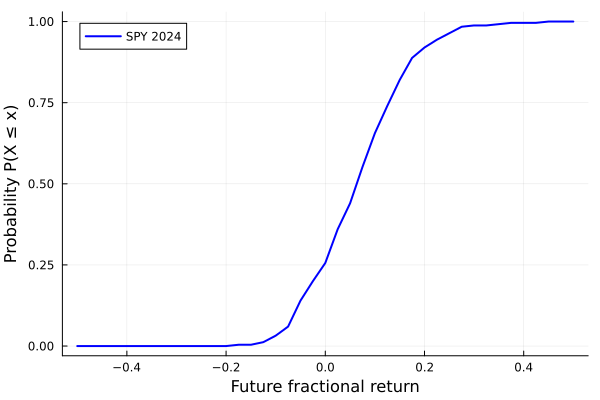

In [33]:
let
    plot(cumulative_probability_array[:,1], cumulative_probability_array[:,2], 
        c=:blue, lw=2, label="$(my_ticker_of_interest) 2024");
    xlabel!("Future fractional return", fontsize=18)
    ylabel!("Probability P(X ≤ x)", fontsize=18)
end

### Discussion
1. Hmmm. The $P(X\leq{x})$ curve looks rough. How would we change our calculations to make a smoother cumulative probability curve?
1. What are the potential risks (or shortcomings) associated with using this approach to estimate the probability of profit?

### Curious: What fractional return have we observed?
We predicted the probability of observing a particular value for the fractional return. What value have we actually observed in the market?

In [36]:
f = let
    Sₒ = my_firm_dataset[1, :volume_weighted_average_price];
    S = my_firm_dataset[end, :volume_weighted_average_price];
    f = (S - Sₒ)/Sₒ
end
println("$(my_ticker_of_interest) has a YTD fractional return of: $(f)")

SPY has a YTD fractional return of: 0.21159067823824848


#### What probability did we give this fractional return?
What is the probability that we'll see a fractional return greater than the observed fractional return in the market?

In [38]:
p = let
    i = findlast(x -> x ≤ f, cumulative_probability_array[:,1])
    p = cumulative_probability_array[i,2]
end
println("Probability that we'll get a return greater than $(f) is $(1 - p)")

Probability that we'll get a return greater than 0.21159067823824848 is 0.07999999999999996


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.